In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from pandas.api.types import CategoricalDtype

import matplotlib.gridspec as gridspec
import matplotlib.patches
from matplotlib import cm
import matplotlib.colors
import matplotlib as mpl
from matplotlib.path import Path
import math, bisect
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter

respath = '../gridpath82/scenarios/' # path to raw scenario results for data processing
scs= ['prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re1_c2p1_tnt1',
      'prm15_fix_wcost_re2_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re2_c2p1_tnt1',
      'prm15_fix_wcost_re3_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re3_c2p1_tnt1',
      'prm15_fix_wcost_re4_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re4_c2p1_tnt1',
      'prm15_fix_wcost_re5_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re5_c2p1_tnt1',
      'prm15_fix_wcost_re6_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re6_c2p1_tnt1',
      'prm15_fix_wcost_re7_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re7_c2p1_tnt1',
      'prm15_fix_wcost_re8_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re8_c2p1_tnt1',
      'prm15_fix_wcost_re9_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re9_c2p1_tnt1',
      'prm15_fix_wcost_re10_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re10_c2p1_tnt1',
      'prm15_fix_wcost_re11_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re11_c2p1_tnt1',
      'prm15_fix_wcost_re12_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re12_c2p1_tnt1',
      'prm15_fix_wcost_re13_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re13_c2p1_tnt1',
      'prm15_fix_wcost_re14_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re14_c2p1_tnt1',
      'prm15_fix_wcost_re15_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re15_c2p1_tnt1',
      'prm15_fix_wcost_re16_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re16_c2p1_tnt1',
      'prm15_fix_wcost_re17_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re17_c2p1_tnt1',
      'prm15_fix_wcost_re18_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re18_c2p1_tnt1',
      'prm15_fix_wcost_re19_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re19_c2p1_tnt1',
      'prm15_fix_wcost_re20_c2p1_co2_cut90p_tnt1','prm15_fix_wcost_re20_c2p1_tnt1']

## Data Processing

In [2]:
all_costs_emissions = pd.DataFrame()
for i in range(len(scs)):
    # operations costs 2020-2050
    op_costs = pd.read_csv(respath+scs[i]+'/results/costs_operations.csv')    
    # multiply by timepoint_weight
    op_costs['variable_om_cost_total'] = op_costs['variable_om_cost']*op_costs['timepoint_weight']*op_costs['number_of_hours_in_timepoint']
    op_costs['fuel_cost_total'] = op_costs['fuel_cost'] * op_costs['timepoint_weight'] * op_costs['number_of_hours_in_timepoint']
    op_costs['startup_cost_total'] = op_costs['startup_cost'] * op_costs['timepoint_weight'] * op_costs['number_of_hours_in_timepoint']
    # check whether timepoint should be multiplied
    op_costs_summary = op_costs.groupby(['period','load_zone'])[['variable_om_cost_total', 'fuel_cost_total', 'startup_cost_total']].sum()
    # capacity costs 2020-2050
    capacity_costs = pd.read_csv(respath+''+str(scs[i])+'/results/costs_capacity_all_projects.csv')    
    capacity_costs_summary = capacity_costs.groupby(['period','load_zone'])[['capacity_cost']].sum()
    # transmission capacity costs 2020-2050
    transmission_costs = pd.read_csv(respath+''+str(scs[i])+'/results/costs_transmission_capacity.csv')
    transmission_costs = transmission_costs.rename(columns={"load_zone_from": "load_zone"})
    transmission_costs_summary = transmission_costs.groupby(['period','load_zone'])[['capacity_cost']].sum()
    transmission_costs_summary.rename(columns = {'capacity_cost': 'transmission_capacity_cost'}, inplace=True)
    # existing capital capacity costs
    all_cap = pd.read_csv(respath+''+str(scs[i])+'/results/capacity_all.csv')
    ecap = all_cap[all_cap.capacity_type == 'gen_spec']
    ecap_tech = ecap.groupby(['period','technology','load_zone'])[['capacity_mw']].sum()
    ecap_tech.reset_index(inplace=True)
    # energy demand 
    load = pd.read_csv(respath+''+str(scs[i])+'/results/load_balance.csv')
    load['mwh'] = load['timepoint_weight'] * load['load_mw']
    load = load.rename(columns={"zone": "load_zone"})
    load_summary = load.groupby(['period','load_zone'])['mwh'].sum()
    # emissions
    emissions = pd.read_csv(respath+''+str(scs[i])+'/results/carbon_emissions_by_project.csv')
    emissions['MtCO2'] = emissions['timepoint_weight'] * emissions['carbon_emissions_tons'] / 10**6  
    emissions_summary = emissions.groupby(['period','load_zone'])['MtCO2'].sum()
    # concatenate costs and sum
    ce_df = pd.concat([op_costs_summary, capacity_costs_summary, transmission_costs_summary, load_summary, emissions_summary], axis=1)
    cols_to_include=['variable_om_cost_total','fuel_cost_total','startup_cost_total','capacity_cost','transmission_capacity_cost']
    
    ce_df['tCO2_per_mwh'] = ce_df['MtCO2']/ce_df['mwh']*10**6
    ce_df['total_costs'] = ce_df.loc[:,ce_df.columns.isin(cols_to_include)].sum(axis=1)
    ce_df['costs_per_mwh'] = ce_df['total_costs']/ce_df['mwh']
    ce_df['var_om_cost_per_mwh'] = ce_df['variable_om_cost_total']/ce_df['mwh']
    ce_df['fuel_cost_per_mwh'] = ce_df['fuel_cost_total']/ce_df['mwh']
    ce_df['startup_cost_per_mwh'] = ce_df['startup_cost_total']/ce_df['mwh']
    ce_df['capacity_cost_per_mwh'] = ce_df['capacity_cost']/ce_df['mwh']
    ce_df['tx_capacity_cost_per_mwh'] = ce_df['transmission_capacity_cost']/ce_df['mwh']
    # add scenario
    ce_df['scs_id'] = scs[i]
    ce_df.reset_index()
    all_costs_emissions = pd.concat([all_costs_emissions, ce_df])
    print(str(i))
cost_emis_df = all_costs_emissions.reset_index()
cost_emis_df = cost_emis_df.fillna(0)
cost_emis_df.to_csv('costs_emissions_tnt1.csv',index=False)

In [3]:
tech_mapper = {'Coal_Sub':'Coal','Coal_Sup':'Coal','Coal_IGCC':'Coal','Gas_CCGT':'Gas','Gas_OCGT':'Gas','Gas_ICE':'Gas',
               'Oil':'Diesel','SolarPV':'Solar','Wind':'Wind','Geothermal':'Geothermal','Biomass':'Biomass','Diesel':'Diesel',
               'Nuclear':'Nuclear','Hydro':'Hydro','Battery':'Battery'}

list_hourly_disp_load = []
for i in range(len(scs)):
    ###Generation-TWh 2020-2050
    alldisp1 = pd.read_csv(respath+scs[i]+'/results/dispatch_all.csv')
    ###rename tech for plotting
    alldisp1['technology'] = alldisp1.technology.map(tech_mapper)
    alldisp1.loc[(alldisp1['technology'] == 'Battery')&(alldisp1['power_mw'] < 0),'technology'] = 'Battery_charge'
    alldisp1.loc[(alldisp1['technology'] == 'Battery')&(alldisp1['power_mw'] >= 0),'technology'] = 'Battery_discharge'
    alldisp1 = alldisp1.fillna(0)
    ###system-wide dispatch by timepoints and tech
    df_hourly_disp = alldisp1.groupby(['timepoint','technology','load_zone'])['power_mw'].sum()/1000
    df_hourly_disp = df_hourly_disp.reset_index()
    ###create pivot table
    pt_hourly_disp = df_hourly_disp.pivot(index=['timepoint','load_zone'], columns='technology', values='power_mw')
    ###calculate load by timepoints
    load_bal = pd.read_csv(respath+scs[i]+'/results/load_balance.csv')
    load_bal = load_bal.groupby(['timepoint','zone'])['load_mw'].sum()/1000
    pt_hourly_disp['load'] = load_bal
    ###calculate curtailment by timepoints
    curt_df = pd.read_csv(respath+scs[i]+'/results/dispatch_variable.csv')
    curt_df = curt_df.groupby(['timepoint','load_zone'])['total_curtailment_mw'].sum()/1000
    pt_hourly_disp['curt'] = curt_df
    ###include scenario name and append to list
    pt_hourly_disp['scs'] = scs[i]
    list_hourly_disp_load.append(pt_hourly_disp)
    print(i)

### Concat pivot tables of all scenarios
df_hourly_disp_load_allscs = pd.concat([list_hourly_disp_load[i] for i in range(len(scs))])
df_hourly_disp_load_allscs = df_hourly_disp_load_allscs.fillna(0)
df_hourly_disp_load_allscs.to_csv('hourly_dispatch_tnt1.csv')

# Curtailment-VRE 2020-2050
vre_curt = pd.DataFrame()
for i in range(len(scs)):
    disp_re = pd.read_csv(respath+scs[i]+'/results/dispatch_variable.csv')
    disp_re['twh'] = disp_re['total_curtailment_mw']*disp_re['timepoint_weight']/(10**6)
    curt_re = disp_re.groupby(['period','load_zone'])['twh'].sum()
    curt_re = curt_re.reset_index()
    curt_re['technology']='curt_vre'
    curt_re['scs'] = scs[i]
    vre_curt = pd.concat([vre_curt,curt_re])
    print(str(i))
vre_curt.to_csv('vre_curtailment_tnt1.csv', index=False)

# Curtailment-Hydro 2020-2050
hyd_curt = pd.DataFrame()
for i in range(len(scs)):
    disp_hydro = pd.read_csv(respath+scs[i]+'/results/dispatch_gen_hydro.csv')
    disp_hydro['twh'] = disp_hydro['scheduled_curtailment_mw']*disp_hydro['timepoint_weight']/(10**6)
    curt_hydro = disp_hydro.groupby(['period','load_zone'])['twh'].sum()
    curt_hydro = curt_hydro.reset_index()
    curt_hydro['technology']='curt_hydro'
    curt_hydro['scs'] = scs[i]
    hyd_curt = pd.concat([hyd_curt,curt_hydro])
    print(str(i))
hyd_curt.to_csv('scheduled_hydro_curtailment_tnt1.csv', index=False)

### Unmet Demand

In [4]:
load_bal = pd.read_csv(respath+scs[0]+'/results/load_balance.csv')
load_bal['month'] = load_bal['timepoint'].astype(str).str[4:6]
load_bal = load_bal.set_index(['zone','period','month','timepoint'])
load_bal[scs[0]] = load_bal['unserved_energy_mw']*load_bal['timepoint_weight']/(10**6)
load_bal = pd.DataFrame(load_bal[scs[0]])
for i in range(1,len(scs)):
    temp_lb=pd.read_csv(respath+scs[i]+'/results/load_balance.csv')
    temp_lb['month'] = temp_lb['timepoint'].astype(str).str[4:6]
    temp_lb = temp_lb.set_index(['zone','period','month','timepoint'])
    temp_lb[scs[i]] = temp_lb['unserved_energy_mw']*temp_lb['timepoint_weight']/(10**6)
    temp_lb = pd.DataFrame(temp_lb[scs[i]])
    load_bal = load_bal.merge(temp_lb, on=['zone','period','month','timepoint'])
load_bal = load_bal.groupby(['period','month','zone']).sum().reset_index()
load_bal.reset_index().to_csv('unmet_demand_tnt1.csv',index=False)

In [26]:
# Monthly Curtailment-VRE 2020-2050
disp_re = pd.read_csv(respath+scs[0]+'/results/dispatch_variable.csv')
disp_re['twh'] = disp_re['total_curtailment_mw']*disp_re['timepoint_weight']/(10**6)
vre_curt = disp_re.groupby(['period','horizon','load_zone'])['twh'].sum().reset_index()\
                 .sort_values(by='horizon').rename(columns={'twh':scs[0]})
for i in range(1,len(scs)):
    temp_lb=pd.read_csv(respath+scs[i]+'/results/dispatch_variable.csv')
    temp_lb['twh'] = temp_lb['total_curtailment_mw']*temp_lb['timepoint_weight']/(10**6)
    temp_re = temp_lb.groupby(['period','horizon','load_zone'])['twh'].sum().reset_index()\
                 .sort_values(by='horizon').rename(columns={'twh':scs[i]})
    vre_curt = vre_curt.merge(temp_re, on=['period','horizon','load_zone'])
vre_curt.to_csv('vre_curtailment_monthly_tnt1.csv',index=False)

### Transmission Operations

In [5]:
list_exim_lz_allscs = []
list_tot_exp_imp_allscs = []
for i in range(len(scs)):
    ## estimate total export/import where exports include transmission losses
    exim = pd.read_csv(respath+scs[i]+'/results/imports_exports.csv')
    exim['imports_twh'] = exim['imports_mw'] * exim['timepoint_weight']/(10**6)
    exim['exports_twh'] = exim['exports_mw'] * exim['timepoint_weight']/(10**6)
    import_lz_as_neg_exp = exim[(exim.exports_twh < 0)].groupby(['period','load_zone'])['exports_twh'].sum()*(-1)
    import_lz_as_pos_imp = exim[(exim.imports_twh > 0)].groupby(['period','load_zone'])['imports_twh'].sum()
    export_lz_as_pos_exp = exim[(exim.exports_twh > 0)].groupby(['period','load_zone'])['exports_twh'].sum()
    export_lz_as_neg_imp = exim[(exim.imports_twh < 0)].groupby(['period','load_zone'])['imports_twh'].sum()*(-1)
    df_exim_lz=pd.concat([import_lz_as_neg_exp,import_lz_as_pos_imp,export_lz_as_pos_exp, export_lz_as_neg_imp],axis=1)
    df_exim_lz.columns = ['import_lz_as_neg_exp','import_lz_as_pos_imp','export_lz_as_pos_exp', 'export_lz_as_neg_imp']
    df_exim_lz = df_exim_lz.fillna(0)
    df_exim_lz['tot_imp_twh'] = df_exim_lz[['import_lz_as_neg_exp','import_lz_as_pos_imp']].sum(axis=1)
    df_exim_lz['tot_exp_twh'] = df_exim_lz[['export_lz_as_pos_exp', 'export_lz_as_neg_imp']].sum(axis=1)
    df_exim_lz['net_imp_twh'] = df_exim_lz['tot_imp_twh'] - df_exim_lz['tot_exp_twh'] ##matches with net_exim below
    df_exim_lz['tot_trade_twh'] = df_exim_lz['tot_imp_twh'] + df_exim_lz['tot_exp_twh']
    df_exim_lz['Scenario'] = scs[i]
    ## estimate transmission losses and exclude from exports   
    trans_op = pd.read_csv(respath+scs[i]+'/results/transmission_operations.csv')
    trans_op['tx_loss_from_twh'] = trans_op['transmission_losses_lz_from']*trans_op['timepoint_weight']/(10**6)
    trans_op['tx_loss_to_twh'] = trans_op['transmission_losses_lz_to']*trans_op['timepoint_weight']/(10**6)
    from_to_losses = trans_op.groupby(['period', 'lz_from'])['tx_loss_to_twh'].sum()
    to_from_losses = trans_op.groupby(['period', 'lz_to'])['tx_loss_from_twh'].sum()
    df_exim_lz_with_losses = pd.concat([df_exim_lz, from_to_losses, to_from_losses],axis=1).fillna(0)
    df_exim_lz_with_losses['tot_loss'] = df_exim_lz_with_losses[['tx_loss_to_twh','tx_loss_from_twh']].sum(axis=1)
    df_exim_lz_with_losses['tot_exp_twh_excl_loss'] = df_exim_lz_with_losses['tot_exp_twh'] - df_exim_lz_with_losses['tot_loss']
    df_exim_lz_with_losses = df_exim_lz_with_losses.reset_index()
    ## separate columns with final export and import data
    df_exim_lz1 = df_exim_lz_with_losses[['period','level_1','tot_imp_twh',\
                                          'tot_exp_twh_excl_loss','net_imp_twh','Scenario']].copy()
    df_exim_lz1.columns = ['period','load_zone','tot_imp_twh','tot_exp_twh_excl_loss','net_imp_twh','Scenario']
    list_exim_lz_allscs.append(df_exim_lz1)
    ## total export import for px plot
    df_imp = df_exim_lz1[['period','load_zone']].copy()
    df_exp = df_exim_lz1[['period','load_zone']].copy()
    df_imp['trade'] = df_exim_lz1['tot_imp_twh']
    df_imp['type'] = 'import'
    df_exp['trade'] = df_exim_lz1['tot_exp_twh_excl_loss']
    df_exp['type'] = np.where(df_exim_lz1["tot_exp_twh_excl_loss"] < 0, 'import', 'export')
    df_exp["trade"] = df_exp["trade"].abs()
    df_tot_exp_imp = pd.concat([df_imp, df_exp])
    df_tot_exp_imp = df_tot_exp_imp.groupby(['type', 'period','load_zone'])['trade'].sum().reset_index()
    df_tot_exp_imp['Scenario'] = scs[i]
    list_tot_exp_imp_allscs.append(df_tot_exp_imp)
    print(str(i))
    
## concat all scenarios
df_exim_lz_allscs = pd.concat([list_exim_lz_allscs[i] for i in range(len(scs))])
df_tot_exp_imp_allscs = pd.concat([list_tot_exp_imp_allscs[i] for i in range(len(scs))]).reset_index().drop(columns='index')
df_tot_exp_imp_allscs['multiplier'] = np.where(df_tot_exp_imp_allscs["type"] == 'import', 1, -1)
df_tot_exp_imp_allscs['trade_1'] = df_tot_exp_imp_allscs['trade'].multiply(df_tot_exp_imp_allscs['multiplier'])
df_tot_exp_imp_allscs.round(decimals=5).to_csv('all_trade_tot_exim_by_lzyr_tnt1.csv', index=False)

# country-level trade
trade_list = []
for i in range(len(scs)):
    trans_op = pd.read_csv(respath+scs[i]+'/results/transmission_operations.csv')
    trans_op['tx_flow_twh'] = trans_op['transmission_flow_mw']*trans_op['timepoint_weight']/(10**6)
    trans_op['tx_loss_from_twh'] = trans_op['transmission_losses_lz_from']*trans_op['timepoint_weight']/(10**6)
    trans_op['tx_loss_to_twh'] = trans_op['transmission_losses_lz_to']*trans_op['timepoint_weight']/(10**6)
    trans_op['net_flow_twh'] = trans_op['tx_flow_twh'] + trans_op['tx_loss_from_twh'] - trans_op['tx_loss_to_twh']
    trans_op['net_flow_twh'] = np.abs(trans_op['net_flow_twh'])
    grp_trans = trans_op.groupby(['lz_from','lz_to','period']).sum().reset_index()\
                        .drop(columns=['timepoint','timepoint_weight','number_of_hours_in_timepoint'])
    grp_trans['scenario'] = scs[i]
    trade_list.append(grp_trans[['lz_from','lz_to','period','net_flow_twh','scenario']])
    
df_trade_list = pd.concat([trade_list[i] for i in range(len(scs))])
df_trade_list.to_csv('total_trade_data_tnt1.csv', index=False)

# TRADE BY TIMEPOINT

list_exim_lz_allscs = []
list_tot_exp_imp_allscs = []
for i in range(len(scs)):
    ## estimate total export/import where exports include transmission losses
    exim = pd.read_csv(respath+scs[i]+'/results/imports_exports.csv')
    exim['imports_twh'] = exim['imports_mw']/(10**6)
    exim['exports_twh'] = exim['exports_mw']/(10**6)
    import_lz_as_neg_exp = exim[(exim.exports_twh < 0)].groupby(['period','load_zone'])['exports_twh'].sum()*(-1)
    import_lz_as_pos_imp = exim[(exim.imports_twh > 0)].groupby(['period','load_zone'])['imports_twh'].sum()
    export_lz_as_pos_exp = exim[(exim.exports_twh > 0)].groupby(['period','load_zone'])['exports_twh'].sum()
    export_lz_as_neg_imp = exim[(exim.imports_twh < 0)].groupby(['period','load_zone'])['imports_twh'].sum()*(-1)
    df_exim_lz=pd.concat([import_lz_as_neg_exp,import_lz_as_pos_imp,export_lz_as_pos_exp, export_lz_as_neg_imp],axis=1)
    df_exim_lz.columns = ['import_lz_as_neg_exp','import_lz_as_pos_imp','export_lz_as_pos_exp', 'export_lz_as_neg_imp']
    df_exim_lz = df_exim_lz.fillna(0)
    df_exim_lz['tot_imp_twh'] = df_exim_lz[['import_lz_as_neg_exp','import_lz_as_pos_imp']].sum(axis=1)
    df_exim_lz['tot_exp_twh'] = df_exim_lz[['export_lz_as_pos_exp', 'export_lz_as_neg_imp']].sum(axis=1)
    df_exim_lz['net_imp_twh'] = df_exim_lz['tot_imp_twh'] - df_exim_lz['tot_exp_twh'] ##matches with net_exim below
    df_exim_lz['tot_trade_twh'] = df_exim_lz['tot_imp_twh'] + df_exim_lz['tot_exp_twh']
    df_exim_lz['Scenario'] = scs[i]
    ## estimate transmission losses and exclude from exports   
    trans_op = pd.read_csv(respath+scs[i]+'/results/transmission_operations.csv')
    trans_op['tx_loss_from_twh'] = trans_op['transmission_losses_lz_from']/(10**6)
    trans_op['tx_loss_to_twh'] = trans_op['transmission_losses_lz_to']/(10**6)
    from_to_losses = trans_op.groupby(['period', 'lz_from'])['tx_loss_to_twh'].sum()
    to_from_losses = trans_op.groupby(['period', 'lz_to'])['tx_loss_from_twh'].sum()
    df_exim_lz_with_losses = pd.concat([df_exim_lz, from_to_losses, to_from_losses],axis=1).fillna(0)
    df_exim_lz_with_losses['tot_loss'] = df_exim_lz_with_losses[['tx_loss_to_twh','tx_loss_from_twh']].sum(axis=1)
    df_exim_lz_with_losses['tot_exp_twh_excl_loss'] = df_exim_lz_with_losses['tot_exp_twh'] - df_exim_lz_with_losses['tot_loss']
    df_exim_lz_with_losses = df_exim_lz_with_losses.reset_index()
    ## separate columns with final export and import data
    df_exim_lz1 = df_exim_lz_with_losses[['period','level_1','tot_imp_twh',\
                                          'tot_exp_twh_excl_loss','net_imp_twh','Scenario']].copy()
    df_exim_lz1.columns = ['period','load_zone','tot_imp_twh','tot_exp_twh_excl_loss','net_imp_twh','Scenario']
    list_exim_lz_allscs.append(df_exim_lz1)
    ## total export import for px plot
    df_imp = df_exim_lz1[['period','load_zone']].copy()
    df_exp = df_exim_lz1[['period','load_zone']].copy()
    df_imp['trade'] = df_exim_lz1['tot_imp_twh']
    df_imp['type'] = 'import'
    df_exp['trade'] = df_exim_lz1['tot_exp_twh_excl_loss']
    df_exp['type'] = np.where(df_exim_lz1["tot_exp_twh_excl_loss"] < 0, 'import', 'export')
    df_exp["trade"] = df_exp["trade"].abs()
    df_tot_exp_imp = pd.concat([df_imp, df_exp])
    df_tot_exp_imp = df_tot_exp_imp.groupby(['type', 'period','load_zone'])['trade'].sum().reset_index()
    df_tot_exp_imp['Scenario'] = scs[i]
    list_tot_exp_imp_allscs.append(df_tot_exp_imp)
    print(str(i))
    
## concat all scenarios
df_exim_lz_allscs = pd.concat([list_exim_lz_allscs[i] for i in range(len(scs))])
df_tot_exp_imp_allscs = pd.concat([list_tot_exp_imp_allscs[i] for i in range(len(scs))]).reset_index().drop(columns='index')
df_tot_exp_imp_allscs['multiplier'] = np.where(df_tot_exp_imp_allscs["type"] == 'import', 1, -1)
df_tot_exp_imp_allscs['trade_1'] = df_tot_exp_imp_allscs['trade'].multiply(df_tot_exp_imp_allscs['multiplier'])
df_tot_exp_imp_allscs.round(decimals=5).to_csv('all_trade_tot_exim_by_lzyr_tnt1.csv', index=False)


# country-level trade
trade_list = []
for i in range(len(scs)):
    trans_op = pd.read_csv(respath+scs[i]+'/results/transmission_operations.csv')
    trans_op['tx_flow_twh'] = trans_op['transmission_flow_mw']/(10**6)
    trans_op['tx_loss_from_twh'] = trans_op['transmission_losses_lz_from']/(10**6)
    trans_op['tx_loss_to_twh'] = trans_op['transmission_losses_lz_to']/(10**6)
    trans_op['net_flow_twh'] = trans_op['tx_flow_twh'] + trans_op['tx_loss_from_twh'] - trans_op['tx_loss_to_twh']
    trans_op['tx_line'] = trans_op['tx_line'].map({'Brazil_Uruguay_New':'Brazil_Uruguay','Brazil_Paraguay_New':'Brazil_Paraguay',
                                                   'Argentina_Uruguay_New':'Argentina_Uruguay','Argentina_Paraguay_New':'Argentina_Paraguay',
                                                   'Argentina_Chile_New':'Argentina_Chile','Argentina_Brazil_New':'Argentina_Brazil',
                                                   'Brazil_Uruguay':'Brazil_Uruguay','Brazil_Paraguay':'Brazil_Paraguay',
                                                   'Argentina_Uruguay':'Argentina_Uruguay','Argentina_Paraguay':'Argentina_Paraguay',
                                                   'Argentina_Chile':'Argentina_Chile','Argentina_Brazil':'Argentina_Brazil'})
    #trans_op['net_flow_twh'] = np.abs(trans_op['net_flow_twh'])
    grp_trans = trans_op.groupby(['timepoint','tx_line','lz_from','lz_to','period']).sum().reset_index()\
                        .drop(columns=['timepoint_weight','number_of_hours_in_timepoint'])
    grp_trans['scenario'] = scs[i]
    trade_list.append(grp_trans[['timepoint','tx_line','lz_from','lz_to','period','net_flow_twh','scenario']])
    print(str(i))
    
df_trade_list = pd.concat([trade_list[i] for i in range(len(scs))])
df_trade_list.to_csv('total_trade_by_timepoint_net_tnt1.csv', index=False)

## Figures

In [2]:
### GENERAL INFORMATION / VARIABLES ###
mercosur = ['Argentina','Brazil','Chile','Paraguay','Uruguay']
datapath = './data/'
periods = [2020,2025,2030,2035,2040,2045,2050]

my_colours = ['#7DF5E0','#008770','#FF96BC','#CA1658','#FFCB31','#AD8200','#84C5FF','#0074DA'] # [green,pink,yellow,blue]
med_colours = ['#008770','#7DF5E0','#CA1658','#FF96BC','#AD8200','#FFCB31','#0074DA','#84C5FF']
palette = {'000':'#FF669E','001':'#D81B60','010':'#10EFC9','011':'#004D40','100':'#63B6FF','101':'#0074DA','110':'#FFC107','111':'#AD8200'}
cap_tech = ['Wind','Solar','Hydro','Fossil']
panels = ['Region-wide'] + mercosur

coal_color = '#343a40'
gas_color = '#6c757d'
hydro_color = '#2a648a'
solar_color = '#ef9226'
wind_color = '#8dc0cd'
nuclear_color = 'darkmagenta'
diesel_color = 'darkred'
other_color = '#f07167'
biomass_color = '#6ba661'
geothermal_color = 'slateblue'
battery_color = '#e7c41f'
pstorage_color = '#6a96ac'
trans_color = 'tan'
curtailment_color = 'red'
imports_color ='#D1FA04'
exports_color = '#FF88F8'

In [5]:
### data files
cost_df = pd.read_csv(datapath+'costs_emissions_tnt1.csv')
hourly_disp = pd.read_parquet(datapath+'hourly_dispatch_tnt1.parquet')
hydcurt = pd.read_csv(datapath+'scheduled_hydro_curtailment_tnt1.csv')
vrecurt = pd.read_csv(datapath+'vre_curtailment_tnt1.csv')
unmet = pd.read_csv(datapath+'unmet_demand_tnt1.csv')
tot_exim = pd.read_csv(datapath+'all_trade_tot_exim_by_lzyr_tnt1.csv')
trd_tp = pd.read_parquet(datapath+'total_trade_by_timepoint_net_tnt1.parquet')
trd_tot = pd.read_csv(datapath+'total_trade_data_tnt1.csv')

cost_df = cost_df[['scs_id','period','load_zone','variable_om_cost_total','fuel_cost_total','startup_cost_total',
                'capacity_cost','transmission_capacity_cost','mwh','MtCO2','total_costs']].groupby('scs_id').sum().reset_index()
cost_df['total_costs'] /= 1000000000
cost_df['capacity_cost'] /= 1000000000
cost_df['variable_om_cost_total'] /= 1000000000
cost_df['fuel_cost_total'] /= 1000000000
cost_df['startup_cost_total'] /= 1000000000
cost_df['emis_policy'] = cost_df.scs_id.str.contains('cut90p')*1
cost_df['exist_trd'] = cost_df.scs_id.str.contains('t1')*1
cost_df['op_char'] = cost_df.scs_id.str.split('_', expand=True)[3].str[2:].astype(int)
cost_df['fixed_pv'] = (cost_df.op_char > 10)*1
cost_df['pol'] = cost_df.emis_policy.astype(str) + cost_df.exist_trd.astype(str)
cost_df['group'] = cost_df.emis_policy.astype(str) + cost_df.exist_trd.astype(str) + cost_df.fixed_pv.astype(str)
cost_df['pol'] = cost_df.pol.replace({'00':'NoCut,Full','01':'NoCut,Lim','10':'90%Cut,Full','11':'90%Cut,Lim'})
difforder=CategoricalDtype(['NoCut,Lim','NoCut,Full','90%Cut,Lim','90%Cut,Full'], ordered=True)
cost_df['pol'] = cost_df['pol'].astype(difforder)

In [6]:
df_tn = hourly_disp[['scs','timepoint','load_zone','Battery_discharge','Battery_charge','curt']].copy(deep=True)
df_tn.timepoint = df_tn.timepoint.astype(str)
df_tn['Year'] = df_tn['timepoint'].str[:4].astype(int)
df_tn['Month'] = df_tn['timepoint'].str[4:6].astype(int)
df_tn['Hour'] = df_tn['timepoint'].str[6:].astype(int)

df_tn_sw_2050 = df_tn[df_tn.Year==2050].groupby(['scs','timepoint','Year','Month','Hour']).sum().reset_index()
df_tn_sw_2050 = df_tn_sw_2050.drop(columns=['scs','load_zone','timepoint']).groupby(['Year','Month','Hour']).mean().reset_index()

df_tn_sw_2050_dis_pt = df_tn_sw_2050.pivot(index='Month',columns='Hour',values='Battery_discharge')
df_tn_sw_2050_ch_pt = df_tn_sw_2050.pivot(index='Month',columns='Hour',values='Battery_charge')
df_tn_sw_2050_ch_pt *= -1
df_tn_sw_2050_curt_pt = df_tn_sw_2050.pivot(index='Month',columns='Hour',values='curt')

df_list = [df_tn_sw_2050_dis_pt,df_tn_sw_2050_ch_pt,df_tn_sw_2050_curt_pt]

df_dispatch_sw = hourly_disp.groupby(['timepoint','scs']).sum().reset_index().set_index('timepoint')
### averages for scenario groupings across all turbines: cut90p.t1.1axis, cut90p.t1.fixed, cut90p.tn.1axis, cut90p.tn.fixedyear,months,hours = '2050',['01','02','03','04','05','06','07','08','09','10','11','12'],['01','24']
df_dispatch_sw = hourly_disp.groupby(['timepoint','scs']).sum().reset_index()
df_dispatch_sw['op_char'] = df_dispatch_sw.scs.str.split('_', expand=True)[3].str[2:].astype(int)
df_dispatch_sw['month'] = df_dispatch_sw.timepoint.astype(str).str[4:6].astype(int)
group1 = df_dispatch_sw[(df_dispatch_sw.op_char<=10) & (df_dispatch_sw.month.isin([4,8,12]))]
group2 = df_dispatch_sw[(df_dispatch_sw.op_char>10) & (df_dispatch_sw.month.isin([4,8,12]))]
group1 = group1.drop(columns=['op_char','scs','load_zone']).groupby(['timepoint','month']).mean().reset_index()
group1['group'] = 1
group2 = group2.drop(columns=['op_char','scs','load_zone']).groupby(['timepoint','month']).mean().reset_index()
group2['group'] = 2
mean_disp = pd.concat([group1,group2])
mean_disp = mean_disp.set_index('timepoint')

In [7]:
vre_curt = pd.read_csv(datapath+'vre_curtailment_monthly_tnt1.csv')
sys_vre_curt = vre_curt.groupby(['period','horizon']).sum().reset_index().drop(columns=['period','index'])
curt_df = sys_vre_curt.melt(id_vars='horizon', value_vars=scs)
curt_df['pol'] = curt_df.variable.str.contains('cut90p')

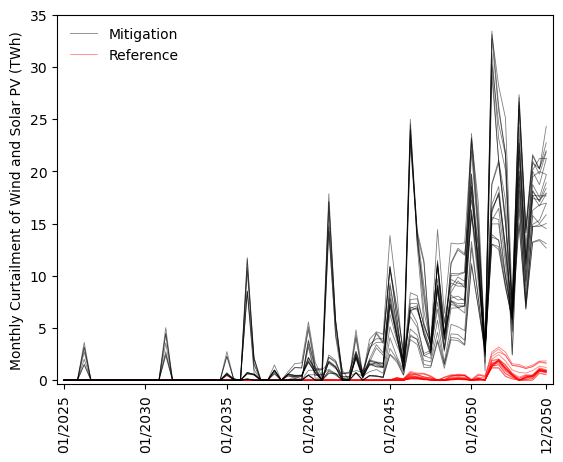

In [9]:
df1 = curt_df[curt_df.horizon>=202500].copy(deep=True)
df1['month'] = list(np.arange(12*6))*len(scs)

plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots()
g = sns.lineplot(data=df1,x='month',y='value',hue='pol',units='variable',estimator=None,
                 palette={True:'k',False:'r'},ax=ax,linewidth=0.6,alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1],labels=['Reference','Mitigation'][::-1],frameon=False,loc='upper left')
                            
plt.xticks([0,12,24,36,48,60,71], ['01/2025','01/2030','01/2035','01/2040','01/2045','01/2050','12/2050'],rotation=90)
plt.ylabel('Monthly Curtailment of Wind and Solar PV (TWh)')
plt.xlabel('')
plt.xlim(-1,72)
plt.ylim(-0.4,35)
plt.savefig('figure_S19.png', dpi=400, bbox_inches='tight')
plt.show()

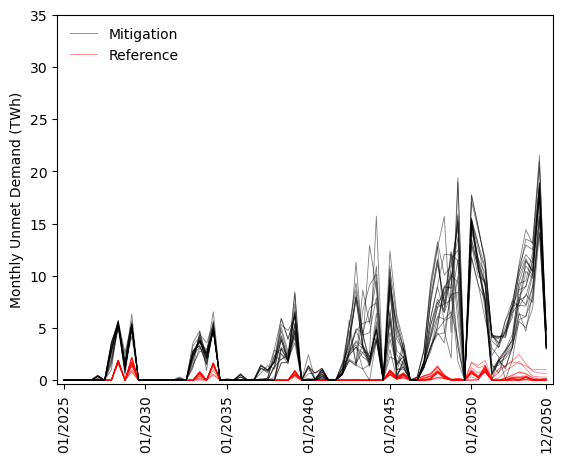

In [13]:
df1 = unmet[unmet.period>=2025].copy(deep=True)
df1['month'] = [i for i in np.arange(12*6) for j in np.arange(5)]
df1 = df1.groupby(['month']).sum().reset_index().drop(columns=['index'])
df1 = df1.melt(id_vars='month', value_vars=scs)
df1['pol'] = df1.variable.str.contains('cut90p')

plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots()
g = sns.lineplot(data=df1,x='month',y='value',hue='pol',units='variable',estimator=None,
                 palette={True:'k',False:'r'},ax=ax,linewidth=0.6,alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1],labels=['Reference','Mitigation'][::-1],frameon=False,loc='upper left')
                            
plt.xticks([0,12,24,36,48,60,71], ['01/2025','01/2030','01/2035','01/2040','01/2045','01/2050','12/2050'],rotation=90)
plt.ylabel('Monthly Unmet Demand (TWh)')
plt.xlabel('')
plt.xlim(-1,72)
plt.ylim(-0.4,35)
plt.savefig('figure_S17.png', dpi=400, bbox_inches='tight')
plt.show()

In [16]:
# using highest cost generation for unmet demand

In [17]:
final_df = pd.DataFrame()
for i in range(len(scs)):
    # operations costs 2020-2050
    op_costs = pd.read_csv(respath+scs[i]+'/results/costs_operations.csv')    
    # multiply by timepoint_weight
    op_costs['variable_om_cost_total'] = op_costs['variable_om_cost']*op_costs['timepoint_weight']*op_costs['number_of_hours_in_timepoint']
    op_costs['fuel_cost_total'] = op_costs['fuel_cost'] * op_costs['timepoint_weight'] * op_costs['number_of_hours_in_timepoint']
    op_costs['startup_cost_total'] = op_costs['startup_cost'] * op_costs['timepoint_weight'] * op_costs['number_of_hours_in_timepoint']
    op_costs_summary = op_costs.groupby(['period','load_zone','timepoint'])[['variable_om_cost_total', 'fuel_cost_total', 'startup_cost_total']].sum()
    # capacity costs
    capacity_costs = pd.read_csv(respath+scs[i]+'/results/costs_capacity_all_projects.csv')    
    capacity_costs_summary = capacity_costs.groupby(['period','load_zone'])[['capacity_cost']].sum()
    capacity_costs_summary['capacity_cost'] /= 8760
    
    # energy demand 
    load = pd.read_csv(respath+''+str(scs[i])+'/results/load_balance.csv')
    load['mwh'] = load['timepoint_weight'] * load['load_mw']
    load = load.rename(columns={"zone": "load_zone"})
    load_summary = load.groupby(['period','load_zone','timepoint'])['mwh'].sum()
    # concatenate costs and sum
    ce_df = pd.concat([op_costs_summary, load_summary], axis=1).reset_index()
    ce_df = ce_df.merge(capacity_costs_summary.reset_index(),on=['period','load_zone'])
    cols_to_include=['variable_om_cost_total','fuel_cost_total','startup_cost_total','capacity_cost']
    
    ce_df['total_costs'] = ce_df.loc[:,ce_df.columns.isin(cols_to_include)].sum(axis=1)
    ce_df['costs_per_mwh'] = ce_df['total_costs']/ce_df['mwh']
    ce_df['var_om_cost_per_mwh'] = ce_df['variable_om_cost_total']/ce_df['mwh']
    ce_df['fuel_cost_per_mwh'] = ce_df['fuel_cost_total']/ce_df['mwh']
    ce_df['startup_cost_per_mwh'] = ce_df['startup_cost_total']/ce_df['mwh']
    
    # add scenario
    ce_df['scs_id'] = scs[i]
    ce_df.reset_index()
    final_df = pd.concat([final_df, ce_df])
    print(str(i))
cost_df = final_df.reset_index()
cost_df = cost_df[cost_df['period'] > 2020].copy(deep=True)
cost_df['month'] = cost_df['timepoint'].astype(str).str[4:6]
cost_df_mo = cost_df[['period','scs_id','costs_per_mwh']].groupby(['period','scs_id']).max().reset_index()

cost_df_mo.to_csv(datapath+'maxcapgencost_tnt1.csv',index=False)

In [15]:
mgc = pd.read_csv(datapath+'maxgencost_tnt1.csv')
mgc

,period,scs_id,costs_per_mwh
0,2025,prm15_fix_wcost_re10_c2p1_co2_cut90p_tnt1,237.880946
1,2025,prm15_fix_wcost_re10_c2p1_tnt1,237.880946
2,2025,prm15_fix_wcost_re11_c2p1_co2_cut90p_tnt1,237.880946
3,2025,prm15_fix_wcost_re11_c2p1_tnt1,237.880946
4,2025,prm15_fix_wcost_re12_c2p1_co2_cut90p_tnt1,237.880946
...,...,...,...
235,2050,prm15_fix_wcost_re7_c2p1_tnt1,24.362811
236,2050,prm15_fix_wcost_re8_c2p1_co2_cut90p_tnt1,39.854345
237,2050,prm15_fix_wcost_re8_c2p1_tnt1,35.989537
238,2050,prm15_fix_wcost_re9_c2p1_co2_cut90p_tnt1,39.849985


In [16]:
unmet = pd.read_csv(datapath+'unmet_demand_tnt1.csv')
unmet = unmet[unmet.period > 2020].copy(deep=True).drop(columns='index')
unmet = pd.melt(unmet,id_vars=['period','month','zone'],value_vars=scs)\
                .rename(columns={'zone':'load_zone','variable':'scs_id','value':'unmet_twh'})
unmet['unmet_twh'] = unmet['unmet_twh']*(1-(unmet['unmet_twh']<0))
unmet

,period,month,load_zone,scs_id,unmet_twh
0,2025,1,Argentina,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,0.0
1,2025,1,Brazil,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,0.0
2,2025,1,Chile,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,0.0
3,2025,1,Paraguay,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,0.0
4,2025,1,Uruguay,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,0.0
...,...,...,...,...,...
14395,2050,12,Argentina,prm15_fix_wcost_re20_c2p1_tnt1,0.0
14396,2050,12,Brazil,prm15_fix_wcost_re20_c2p1_tnt1,0.0
14397,2050,12,Chile,prm15_fix_wcost_re20_c2p1_tnt1,0.0
14398,2050,12,Paraguay,prm15_fix_wcost_re20_c2p1_tnt1,0.0


In [17]:
short_cost = unmet.merge(mgc,on=['period','scs_id']).sort_values(by=['scs_id','period','load_zone'])
short_cost['added_cost_$M'] = short_cost['costs_per_mwh']*short_cost['unmet_twh']
short_cost = short_cost.groupby(['period','load_zone','scs_id']).sum().reset_index().drop(columns=['month','costs_per_mwh'])
short_cost = short_cost.sort_values(by='added_cost_$M')
#short_cost.to_csv(datapath+'cost_of_shortfalls.csv', index=False)
short_cost

,period,load_zone,scs_id,unmet_twh,added_cost_$M
152,2025,Paraguay,prm15_fix_wcost_re6_c2p1_co2_cut90p_tnt1,0.000000,0.000000
763,2040,Uruguay,prm15_fix_wcost_re11_c2p1_tnt1,0.000000,0.000000
765,2040,Uruguay,prm15_fix_wcost_re12_c2p1_tnt1,0.000000,0.000000
749,2040,Paraguay,prm15_fix_wcost_re4_c2p1_tnt1,0.000000,0.000000
750,2040,Paraguay,prm15_fix_wcost_re5_c2p1_co2_cut90p_tnt1,0.000000,0.000000
...,...,...,...,...,...
58,2025,Brazil,prm15_fix_wcost_re19_c2p1_co2_cut90p_tnt1,16.759863,3986.851973
64,2025,Brazil,prm15_fix_wcost_re2_c2p1_co2_cut90p_tnt1,13.899065,4278.406170
1066,2050,Brazil,prm15_fix_wcost_re3_c2p1_co2_cut90p_tnt1,55.627244,4383.994354
1050,2050,Brazil,prm15_fix_wcost_re15_c2p1_co2_cut90p_tnt1,61.863921,4573.042044


In [18]:
short_cost.groupby(['scs_id']).sum().reset_index().drop(columns='period')

,scs_id,load_zone,unmet_twh,added_cost_$M
0,prm15_fix_wcost_re10_c2p1_co2_cut90p_tnt1,ParaguayUruguayArgentinaChileParaguayArgentina...,154.338635,11751.769755
1,prm15_fix_wcost_re10_c2p1_tnt1,UruguayArgentinaParaguayChileUruguayArgentinaB...,11.116729,1469.045194
2,prm15_fix_wcost_re11_c2p1_co2_cut90p_tnt1,ParaguayUruguayArgentinaChileParaguayUruguayAr...,237.723195,12349.216102
3,prm15_fix_wcost_re11_c2p1_tnt1,UruguayUruguayArgentinaParaguayChileUruguayArg...,9.556162,1384.085413
4,prm15_fix_wcost_re12_c2p1_co2_cut90p_tnt1,ParaguayUruguayArgentinaArgentinaChileParaguay...,268.328152,15111.480562
5,prm15_fix_wcost_re12_c2p1_tnt1,UruguayArgentinaChileParaguayUruguayArgentinaB...,14.309005,1673.819271
6,prm15_fix_wcost_re13_c2p1_co2_cut90p_tnt1,ParaguayUruguayArgentinaChileParaguayUruguayAr...,270.056633,17821.311426
7,prm15_fix_wcost_re13_c2p1_tnt1,UruguayArgentinaChileParaguayUruguayArgentinaB...,11.810976,1161.965482
8,prm15_fix_wcost_re14_c2p1_co2_cut90p_tnt1,ParaguayUruguayArgentinaArgentinaParaguayUrugu...,274.893260,15063.130108
9,prm15_fix_wcost_re14_c2p1_tnt1,UruguayChileArgentinaChileParaguayUruguayArgen...,14.989239,1509.448717


In [19]:
costs_df = pd.read_csv(datapath+'costs_emissions_tnt1.csv')
costs_df

,period,load_zone,variable_om_cost_total,fuel_cost_total,startup_cost_total,capacity_cost,transmission_capacity_cost,mwh,MtCO2,tCO2_per_mwh,total_costs,costs_per_mwh,var_om_cost_per_mwh,fuel_cost_per_mwh,startup_cost_per_mwh,capacity_cost_per_mwh,tx_capacity_cost_per_mwh,scs_id
0,2020,Argentina,9.403791e+08,1.315519e+09,3.315753e+06,7.184157e+08,0.0,1.365405e+08,31.936468,0.233897,2.977630e+09,21.807673,6.887182,9.634648,0.024284,5.261559,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
1,2020,Brazil,3.302340e+09,6.684639e+09,0.000000e+00,2.606094e+09,0.0,6.568239e+08,47.784042,0.072750,1.259307e+10,19.172680,5.027741,10.177218,0.000000,3.967722,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
2,2020,Chile,3.218281e+08,1.346618e+09,0.000000e+00,7.526559e+08,0.0,8.292291e+07,21.829983,0.263256,2.421102e+09,29.197021,3.881051,16.239396,0.000000,9.076573,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
3,2020,Paraguay,3.275001e+08,0.000000e+00,0.000000e+00,3.046485e+06,0.0,2.220374e+07,0.000000,0.000000,3.305466e+08,14.886977,14.749771,0.000000,0.000000,0.137206,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
4,2020,Uruguay,4.097329e+07,8.389764e+07,1.230116e+06,1.541036e+08,0.0,1.352470e+07,0.289217,0.021384,2.802046e+08,20.717994,3.029516,6.203291,0.090953,11.394234,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2050,Argentina,1.862575e+09,4.254988e+09,0.000000e+00,9.664879e+09,0.0,3.777254e+08,103.746335,0.274661,1.578244e+10,41.782841,4.931029,11.264765,0.000000,25.587047,0.0,prm15_fix_wcost_re20_c2p1_tnt1
1396,2050,Brazil,5.317628e+09,1.306875e+10,0.000000e+00,3.452371e+10,0.0,1.464977e+09,141.654315,0.096694,5.291009e+10,36.116668,3.629837,8.920788,0.000000,23.566043,0.0,prm15_fix_wcost_re20_c2p1_tnt1
1397,2050,Chile,9.037029e+08,2.709757e+09,0.000000e+00,2.741136e+09,0.0,1.780555e+08,67.287548,0.377902,6.354595e+09,35.688837,5.075399,15.218604,0.000000,15.394835,0.0,prm15_fix_wcost_re20_c2p1_tnt1
1398,2050,Paraguay,3.276802e+08,3.210179e+06,4.282328e+05,1.535247e+09,0.0,9.272710e+07,0.012584,0.000136,1.866565e+09,20.129662,3.533812,0.034620,0.004618,16.556611,0.0,prm15_fix_wcost_re20_c2p1_tnt1


In [20]:
new_tot_cost = costs_df[['scs_id','period','load_zone','total_costs']]\
                .merge(short_cost[['scs_id','period','load_zone','added_cost_$M']],
                      on=['scs_id','period','load_zone'],how='outer')
new_tot_cost = new_tot_cost.fillna(0)
new_tot_cost['new_tot_cost'] = new_tot_cost['total_costs']+(new_tot_cost['added_cost_$M']*1000000)
new_tot_cost_sw = new_tot_cost.groupby(['scs_id']).sum().reset_index()
new_tot_cost_sw['load_zone'] = 'Region-wide'
full_cost_tot = pd.concat([new_tot_cost,new_tot_cost_sw])
full_cost_tot['new_tot_cost'] /= 1000000000
tot = full_cost_tot.groupby(['scs_id','load_zone']).sum().reset_index().drop(columns='period')
tot['emis_policy'] = tot.scs_id.str.contains('cut90p')*1
tot['op_char'] = tot.scs_id.str.split('_', expand=True)[3].str[2:].astype(int)
tot['fixed_pv'] = (tot.op_char > 10)*1
tot['pol'] = tot.emis_policy.astype(str)
tot['group'] = tot.emis_policy.astype(str) + tot.fixed_pv.astype(str)
tot['pol'] = tot.pol.replace({'0':'NoCut','1':'90%Cut'})
difforder=CategoricalDtype(['NoCut','90%Cut'], ordered=True)
tot['pol'] = tot['pol'].astype(difforder)
tot

,scs_id,load_zone,total_costs,added_cost_$M,new_tot_cost,emis_policy,op_char,fixed_pv,pol,group
0,prm15_fix_wcost_re10_c2p1_co2_cut90p_tnt1,Argentina,5.720569e+10,371.562531,57.577248,1,10,0,90%Cut,10
1,prm15_fix_wcost_re10_c2p1_co2_cut90p_tnt1,Brazil,2.067536e+11,8631.846968,215.385405,1,10,0,90%Cut,10
2,prm15_fix_wcost_re10_c2p1_co2_cut90p_tnt1,Chile,3.053599e+10,2679.963187,33.215958,1,10,0,90%Cut,10
3,prm15_fix_wcost_re10_c2p1_co2_cut90p_tnt1,Paraguay,5.303247e+09,9.389557,5.312637,1,10,0,90%Cut,10
4,prm15_fix_wcost_re10_c2p1_co2_cut90p_tnt1,Region-wide,3.062254e+11,11751.769755,317.977183,1,10,0,90%Cut,10
...,...,...,...,...,...,...,...,...,...,...
235,prm15_fix_wcost_re9_c2p1_tnt1,Brazil,2.163293e+11,1236.361452,217.565707,0,9,0,NoCut,00
236,prm15_fix_wcost_re9_c2p1_tnt1,Chile,2.610613e+10,0.000000,26.106135,0,9,0,NoCut,00
237,prm15_fix_wcost_re9_c2p1_tnt1,Paraguay,3.497196e+09,294.566195,3.791762,0,9,0,NoCut,00
238,prm15_fix_wcost_re9_c2p1_tnt1,Region-wide,3.032467e+11,1565.040529,304.811756,0,9,0,NoCut,00


C:\Users\jaw22\AppData\Local\Temp\ipykernel_14396\1292476201.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference +\nStranded Coord.',
C:\Users\jaw22\AppData\Local\Temp\ipykernel_14396\1292476201.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference +\nStranded Coord.',
C:\Users\jaw22\AppData\Local\Temp\ipykernel_14396\1292476201.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference +\nStranded Coord.',
C:\Users\jaw22\AppData\Local\Temp\ipykernel_14396\1292476201.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference +\nStranded Coord.',


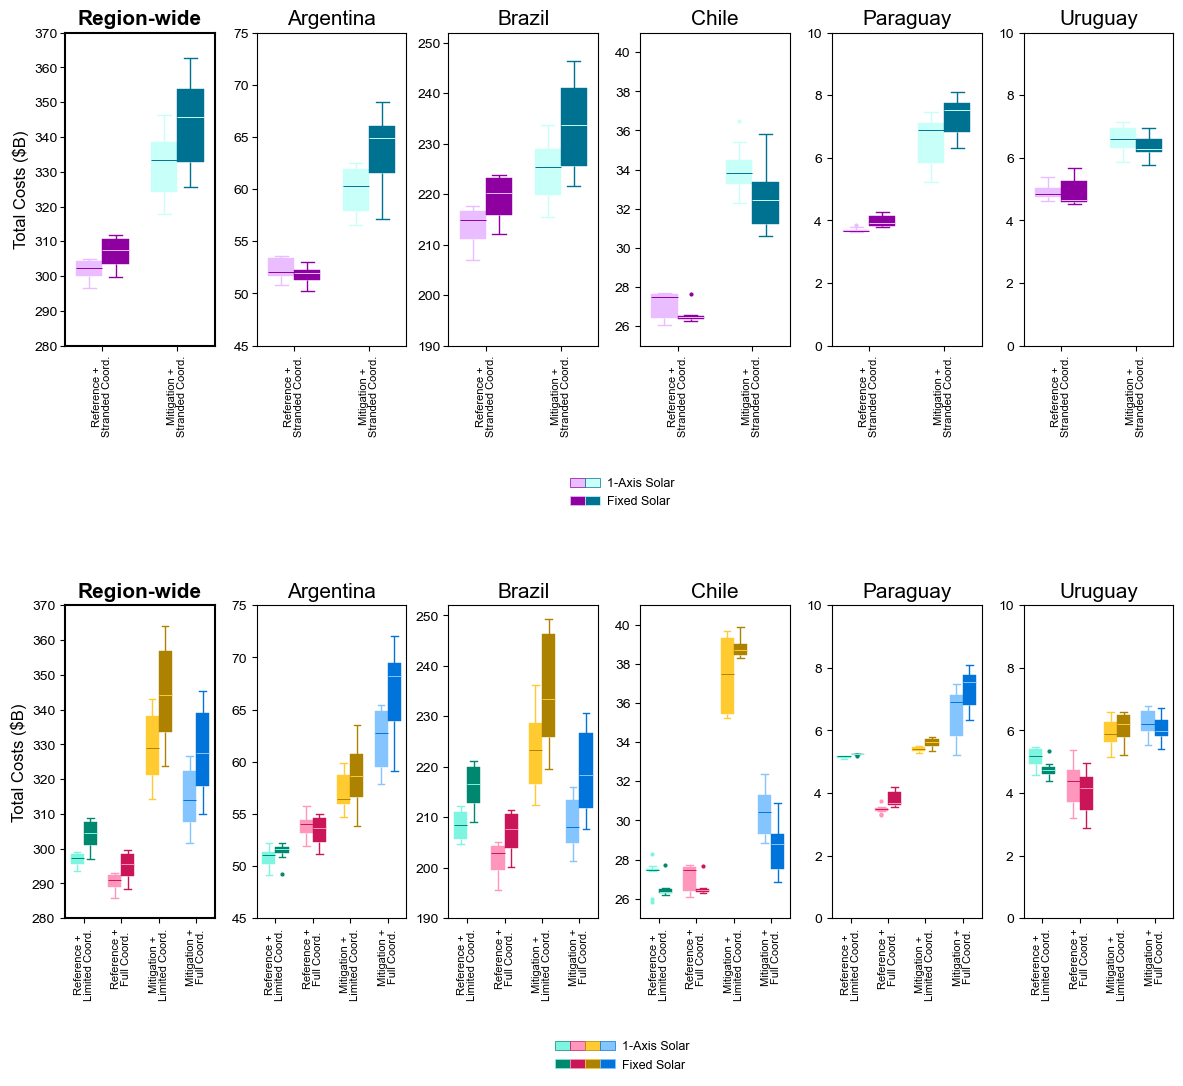

In [24]:
plt.rcParams.update(plt.rcParamsDefault)
font = FontProperties()
font.set_name('Open Sans')
plt.rcParams["font.family"] = "Arial"

my_colours = ['#e9bdff','#c8fff8','#8f00a0','#007291']
med_colours = ['#8f00a0','#007291','#e9bdff','#c8fff8']
panels = ['Region-wide'] + mercosur

split_tx_cost_df = pd.read_csv(datapath+'split_tx_cost_df80.csv')

my_colours80 = ['#7DF5E0','#FF96BC','#FFCB31','#84C5FF','#008770','#CA1658','#AD8200','#0074DA']
med_colours80 = ['#008770','#CA1658','#AD8200','#0074DA','#7DF5E0','#FF96BC','#FFCB31','#84C5FF']

cost_cols = ['new_tot_cost','new_total_cost']
cost_label = 'Total Costs ($B)'
ylims = [(280,370),(45,75),(190,252),(25,41),(0,10),(0,10)]

fig = plt.figure(constrained_layout=False, figsize = (14.3,11.5))
gs = fig.add_gridspec(2,6, width_ratios=[1,1,1,1,1,1], height_ratios = [1,1], wspace=0.28, hspace=0.83)

# plot capacities
for j in range(len(panels)):
    ax = fig.add_subplot(gs[0,j])
    g = sns.boxplot(data=tot[tot.load_zone==panels[j]],x='pol',y=cost_cols[0],hue='fixed_pv', width=0.7,
                    medianprops={"linewidth": .7,'color':'k','label':'_median_','solid_capstyle':'butt'},saturation=1,
                    flierprops={"marker": "o",'markerfacecolor':'none','markeredgecolor':'k','markersize':2},
                    boxprops={"linewidth": .3,'edgecolor':'k'})
    ax.legend([],frameon=False)
    boxes = ax.findobj(matplotlib.patches.PathPatch)
    for color, box in zip(my_colours, boxes):
        box.set_facecolor(color)
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    if len(box_patches) == 0:
        box_patches = ax.artists
    num_patches = len(box_patches)
    if num_patches > 0:
        lines_per_boxplot = len(ax.lines) // num_patches
        for k, patch in enumerate(box_patches):
            col = patch.get_facecolor()
            patch.set_edgecolor(col)
            for line in ax.lines[k * lines_per_boxplot: (k + 1) * lines_per_boxplot]:
                line.set_color(col)
                line.set_mfc(col)  # facecolor of fliers
                line.set_mec(col)  # edgecolor of fliers
        median_lines = [line for line in ax.get_lines() if line.get_label() == '_median_']
        for k, line in enumerate(median_lines):
            line.set_color(med_colours[k])
    ax.set_title(panels[j],fontsize=15)
    if j==0:
        ax.set_title(panels[j],fontsize=15,fontweight='bold')
    if j==0:
        [x.set_linewidth(1.5) for x in ax.spines.values()]
        ax.set_ylabel(cost_label,fontsize=12)
    else:
        ax.set_ylabel('')

    ax.set_xticklabels(['Reference +\nStranded Coord.',
                        'Mitigation +\nStranded Coord.'],
                        fontsize=8,rotation=90,linespacing=1)
    if j<3:
        ax.tick_params(axis='y',pad=2)
    ax.set_xlabel('')
    ax.set_ylim(ylims[j])
pa1 = Patch(facecolor=my_colours[0], edgecolor=med_colours[0],linewidth=0.5)
pa2 = Patch(facecolor=my_colours[1], edgecolor=med_colours[1],linewidth=0.5)
pb1 = Patch(facecolor=my_colours[2], edgecolor=med_colours[2],linewidth=0.5)
pb2 = Patch(facecolor=my_colours[3], edgecolor=med_colours[3],linewidth=0.5)
ax.legend(handles=[pa1, pb1, pa2, pb2],
          labels=['', '', '1-Axis Solar', 'Fixed Solar'],
          ncol=2, handletextpad=0.5, handlelength=1.2, columnspacing=-0.5,
          loc='center', fontsize=9,frameon=False,bbox_to_anchor=(-2.68,-0.47))

# plot capacities
for j in range(len(panels)):
    ax = fig.add_subplot(gs[1,j])
    g = sns.boxplot(data=split_tx_cost_df[split_tx_cost_df.load_zone==panels[j]],x='pol',y=cost_cols[1],hue='fixed_pv', width=0.7,
                    medianprops={"linewidth": .7,'color':'k','label':'_median_','solid_capstyle':'butt'},saturation=1,
                    flierprops={"marker": "o",'markerfacecolor':'none','markeredgecolor':'k','markersize':2},
                    boxprops={"linewidth": .3,'edgecolor':'k'})
    ax.legend([],frameon=False)
    boxes = ax.findobj(matplotlib.patches.PathPatch)
    for color, box in zip(my_colours80, boxes):
        box.set_facecolor(color)
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    if len(box_patches) == 0:
        box_patches = ax.artists
    num_patches = len(box_patches)
    if num_patches > 0:
        lines_per_boxplot = len(ax.lines) // num_patches
        for k, patch in enumerate(box_patches):
            col = patch.get_facecolor()
            patch.set_edgecolor(col)
            for line in ax.lines[k * lines_per_boxplot: (k + 1) * lines_per_boxplot]:
                line.set_color(col)
                line.set_mfc(col)  # facecolor of fliers
                line.set_mec(col)  # edgecolor of fliers
        median_lines = [line for line in ax.get_lines() if line.get_label() == '_median_']
        for k, line in enumerate(median_lines):
            line.set_color(med_colours80[k])
    ax.set_title(panels[j],fontsize=15)
    if j==0:
        ax.set_title(panels[j],fontsize=15,fontweight='bold')
        [x.set_linewidth(1.5) for x in ax.spines.values()]
        ax.set_ylabel(cost_label,fontsize=12)
    else:
        ax.set_ylabel('')

    ax.set_xticklabels(['Reference +\nLimited Coord.','Reference +\nFull Coord.',
                        'Mitigation +\nLimited Coord.','Mitigation +\nFull Coord.'],
                        fontsize=8,rotation=90,linespacing=1)
    ax.set_xlabel('')
    ax.set_ylim(ylims[j])
pa1 = Patch(facecolor=my_colours80[0], edgecolor=med_colours80[0],linewidth=0.5)
pa2 = Patch(facecolor=my_colours80[1], edgecolor=med_colours80[1],linewidth=0.5)
pa3 = Patch(facecolor=my_colours80[2], edgecolor=med_colours80[2],linewidth=0.5)
pa4 = Patch(facecolor=my_colours80[3], edgecolor=med_colours80[3],linewidth=0.5)
pb1 = Patch(facecolor=my_colours80[4], edgecolor=med_colours80[4],linewidth=0.5)
pb2 = Patch(facecolor=my_colours80[5], edgecolor=med_colours80[5],linewidth=0.5)
pb3 = Patch(facecolor=my_colours80[6], edgecolor=med_colours80[6],linewidth=0.5)
pb4 = Patch(facecolor=my_colours80[7], edgecolor=med_colours80[7],linewidth=0.5)
ax.legend(handles=[pa1, pb1, pa2, pb2, pa3, pb3, pa4, pb4],
          labels=['', '', '', '', '', '', '1-Axis Solar', 'Fixed Solar'],
          ncol=4, handletextpad=0.5, handlelength=1.2, columnspacing=-0.5,
          loc='center', fontsize=9,frameon=False,bbox_to_anchor=(-2.68,-0.44))
fig.savefig('figure_S18.png', bbox_inches='tight', dpi=600)
plt.show()

In [27]:
load_bal = pd.read_csv(respath+scs[0]+'/results/load_balance.csv')
load_bal.timepoint = load_bal.timepoint.astype(str)
load_bal = load_bal.set_index(['zone','period','timepoint'])
load_bal['unmet_gw'] = (load_bal['unserved_energy_mw']*(load_bal['unserved_energy_mw']>0))/1000
load_bal['scs'] = scs[0]
load_bal = pd.DataFrame(load_bal[['unmet_gw','scs']])

for i in range(1,len(scs)):
    temp_lb=pd.read_csv(respath+scs[i]+'/results/load_balance.csv')
    temp_lb.timepoint = temp_lb.timepoint.astype(str)
    temp_lb = temp_lb.set_index(['zone','period','timepoint'])
    temp_lb['unmet_gw'] = (temp_lb['unserved_energy_mw']*(temp_lb['unserved_energy_mw']>0))/1000
    temp_lb['scs'] = scs[i]
    temp_lb = pd.DataFrame(temp_lb[['unmet_gw','scs']])
    load_bal = pd.concat([load_bal,temp_lb])
load_bal.reset_index().to_csv(datapath+'unmet_demand_hourly_tnt1.csv',index=False)

In [29]:
unmet_hr = pd.read_parquet(datapath+'unmet_demand_hourly_tnt1.parquet') #units: GW or GWh
unmet_hr.timepoint = unmet_hr.timepoint.astype(str)
unmet_hr['Year'] = unmet_hr['timepoint'].str[:4].astype(int)
unmet_hr['Month'] = unmet_hr['timepoint'].str[4:6].astype(int)
unmet_hr['Hour'] = unmet_hr['timepoint'].str[6:].astype(int)
unmet0 = unmet_hr[unmet_hr.scs.isin([i for i in scs if 'cut90p' not in i])].copy(deep=True).drop(columns=['period','timepoint'])
unmet1 = unmet_hr[unmet_hr.scs.isin([i for i in scs if 'cut90p' in i])].copy(deep=True).drop(columns=['period','timepoint'])
unmet1

,zone,unmet_gw,scs,Year,Month,Hour
0,Argentina,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,2020,1,1
1,Argentina,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,2020,1,2
2,Argentina,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,2020,1,3
3,Argentina,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,2020,1,4
4,Argentina,0.0,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1,2020,1,5
...,...,...,...,...,...,...
393115,Uruguay,0.0,prm15_fix_wcost_re20_c2p1_co2_cut90p_tnt1,2050,12,20
393116,Uruguay,0.0,prm15_fix_wcost_re20_c2p1_co2_cut90p_tnt1,2050,12,21
393117,Uruguay,0.0,prm15_fix_wcost_re20_c2p1_co2_cut90p_tnt1,2050,12,22
393118,Uruguay,0.0,prm15_fix_wcost_re20_c2p1_co2_cut90p_tnt1,2050,12,23


In [30]:
unm0_2050 = unmet0[unmet0.Year==2050].drop(columns='zone').groupby(['scs','Year','Month','Hour']).sum().reset_index()
unm1_2050 = unmet1[unmet1.Year==2050].drop(columns='zone').groupby(['scs','Year','Month','Hour']).sum().reset_index()

df0_sw_2050 = unm0_2050.drop(columns=['scs']).groupby(['Year','Month','Hour']).mean().reset_index()
df1_sw_2050 = unm1_2050.drop(columns=['scs']).groupby(['Year','Month','Hour']).mean().reset_index()

pt0_sw_2050 = df0_sw_2050.pivot(index='Month',columns='Hour',values='unmet_gw')
pt1_sw_2050 = df1_sw_2050.pivot(index='Month',columns='Hour',values='unmet_gw')

pt1_sw_2050

Hour,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
Month,,,,,,,,,,,,,,,,,,,,,
1,35.899410,24.503898,17.147141,25.031695,22.038155,26.857162,21.961991,31.395672,41.063739,35.092951,...,7.119521,13.778221,9.017612,6.737071,4.630750,18.140841,17.618564,18.076137,22.773543,23.564375
2,27.622282,20.856390,15.929950,18.623345,23.631906,22.254835,27.830684,27.161387,31.373093,43.489885,...,3.632011,4.186413,10.795818,2.344262,2.579921,5.982559,16.551092,20.420449,15.139307,31.646793
3,17.251284,16.147330,16.897122,15.453475,18.497402,16.035446,17.891426,14.690898,20.252290,18.621491,...,3.307637,3.839409,4.508585,1.612992,2.883522,3.482819,12.166979,13.143915,12.665917,24.629276
4,6.471962,5.861869,6.664129,6.383664,5.512392,4.514186,4.305606,4.828305,5.764598,5.980222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.706987,3.180570,6.394205,6.977838
5,6.987078,7.049530,7.779811,6.920619,5.374123,6.423744,3.488832,5.121675,4.016348,6.745934,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.362541,1.746164,2.815393,5.867151,6.801943
6,8.400985,8.231326,8.963187,9.286818,7.807845,5.733673,5.306608,6.874807,7.426118,8.396217,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.202776,1.400965,4.470913,8.602221,6.261297
7,11.931788,12.207245,10.916304,9.730531,8.870776,7.454788,6.977051,8.206361,8.961280,9.226888,...,3.072840,2.523795,2.062095,2.018824,1.558614,2.428141,4.976650,7.370833,11.524953,10.093976
8,24.796239,15.936775,15.338320,18.895269,16.385538,17.991717,16.516704,22.415833,25.917413,18.905028,...,0.019902,0.000000,0.000000,0.000000,0.208478,2.129238,5.907200,10.782854,15.359548,14.225508
9,22.375424,20.435987,14.558122,19.523598,17.516393,30.787541,19.663876,24.512216,31.973149,18.236811,...,1.579439,1.722260,2.957782,0.631187,2.231469,4.759136,11.966461,11.951207,13.907608,17.284495


In [31]:
hourly_disp

,timepoint,load_zone,Battery_charge,Battery_discharge,Biomass,Coal,Diesel,Gas,Geothermal,Hydro,Nuclear,Solar,Wind,load,curt,scs
0,20200101,Argentina,0.0,0.0,0.034500,0.0,0.0,6.841165,0.00,5.976290,1.755,0.0,1.013670,15.8365,0.000000,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
1,20200101,Brazil,0.0,0.0,10.519575,0.0,0.0,3.150001,0.00,58.968614,1.990,0.0,0.936810,75.5650,0.000000,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
2,20200101,Chile,0.0,0.0,0.354000,0.0,0.0,5.187000,0.04,2.683133,0.000,0.0,1.579410,9.8445,0.000000,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
3,20200101,Paraguay,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,2.617700,0.000,0.0,0.000000,2.6167,0.000000,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
4,20200101,Uruguay,0.0,0.0,0.318750,0.0,0.0,0.000000,0.00,0.542230,0.000,0.0,0.953820,1.5838,0.000000,prm15_fix_wcost_re1_c2p1_co2_cut90p_tnt1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403195,20501224,Argentina,0.0,0.0,0.000000,0.0,0.0,27.208218,0.00,5.698274,1.755,0.0,8.924517,43.2649,0.000000,prm15_fix_wcost_re20_c2p1_tnt1
403196,20501224,Brazil,0.0,0.0,8.851650,0.0,0.0,32.107960,0.00,64.473967,1.990,0.0,66.786723,174.4558,0.000000,prm15_fix_wcost_re20_c2p1_tnt1
403197,20501224,Chile,0.0,0.0,0.354000,0.0,0.0,16.348248,0.04,5.063995,0.000,0.0,0.000000,21.8072,0.000000,prm15_fix_wcost_re20_c2p1_tnt1
403198,20501224,Paraguay,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,8.132370,0.000,0.0,3.073630,11.2050,1.999052,prm15_fix_wcost_re20_c2p1_tnt1


In [32]:
dfc = hourly_disp[['scs','timepoint','load_zone','curt']].copy(deep=True)
dfc['curt']
dfc.timepoint = dfc.timepoint.astype(str)
dfc['Year'] = dfc['timepoint'].str[:4].astype(int)
dfc['Month'] = dfc['timepoint'].str[4:6].astype(int)
dfc['Hour'] = dfc['timepoint'].str[6:].astype(int)

dfc0 = dfc[dfc.scs.isin([i for i in scs if 'cut90p' not in i])].copy(deep=True)
dfc1 = dfc[dfc.scs.isin([i for i in scs if 'cut90p' in i])].copy(deep=True)

dfc0_sw_2050 = dfc0[dfc0.Year==2050].drop(columns='load_zone').groupby(['scs','timepoint','Year','Month','Hour']).sum().reset_index()
dfc1_sw_2050 = dfc1[dfc1.Year==2050].drop(columns='load_zone').groupby(['scs','timepoint','Year','Month','Hour']).sum().reset_index()
dfc0_sw_2050 = dfc0_sw_2050.drop(columns=['scs','timepoint']).groupby(['Year','Month','Hour']).mean().reset_index()
dfc1_sw_2050 = dfc1_sw_2050.drop(columns=['scs','timepoint']).groupby(['Year','Month','Hour']).mean().reset_index()

dfc0_pt = dfc0_sw_2050.pivot(index='Month',columns='Hour',values='curt')
dfc1_pt = dfc1_sw_2050.pivot(index='Month',columns='Hour',values='curt')
dfc1_pt

Hour,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
Month,,,,,,,,,,,,,,,,,,,,,
1,23.049550,32.721593,32.697659,32.263688,31.687331,30.013785,28.723635,25.794570,19.657195,18.320484,...,20.456811,21.239105,21.944086,20.454286,24.495586,21.986042,23.030667,20.754107,23.308001,26.831395
2,13.086390,24.324177,24.841396,26.732956,26.879770,25.194129,23.775075,21.047794,15.136923,11.826511,...,10.763192,14.095113,11.446745,17.707924,19.530673,13.873588,13.335317,9.859347,11.040294,16.459769
3,1.153877,6.582481,7.874775,8.581352,8.401889,7.794018,6.242475,4.469428,1.292334,0.113354,...,5.487660,5.629250,3.742501,4.270083,2.673548,1.872278,0.411771,0.081471,0.207597,0.288271
4,23.877639,31.983460,38.379426,35.427305,36.170706,36.546144,29.527605,27.620095,26.188968,20.439147,...,33.428886,37.006904,34.520893,36.032007,37.583783,32.157319,24.694463,21.448679,17.547784,24.941165
5,19.272585,30.309959,30.752181,32.196336,32.230145,34.620573,32.119163,28.868610,26.123546,22.486463,...,21.630691,24.169839,26.578070,29.047232,30.404748,25.415218,18.157987,17.740110,21.518641,23.685043
6,10.948300,20.161677,20.083814,21.927039,24.916092,24.209634,21.723700,18.202178,15.775140,14.298749,...,30.962032,30.878895,26.084119,29.754977,19.969113,16.261404,9.258200,11.940470,9.698035,13.161212
7,2.622540,8.195778,8.484986,9.225450,8.753576,8.592982,8.018409,6.462581,3.843523,2.430843,...,16.701032,14.341405,10.699902,14.260286,7.891806,5.617492,3.448069,2.317305,3.449925,0.979471
8,22.832043,34.063994,36.445089,37.504296,38.089441,36.233872,34.293119,32.847618,29.300914,27.069224,...,33.516945,28.856896,25.950769,31.488835,27.081401,25.159686,15.900226,17.296085,15.142907,22.073128
9,8.405464,20.859056,23.146355,25.997785,25.276224,25.032306,22.325993,19.694396,15.885482,12.551078,...,11.769551,12.047912,11.652760,16.865344,15.747976,14.915770,11.733999,5.497731,6.450660,10.802448


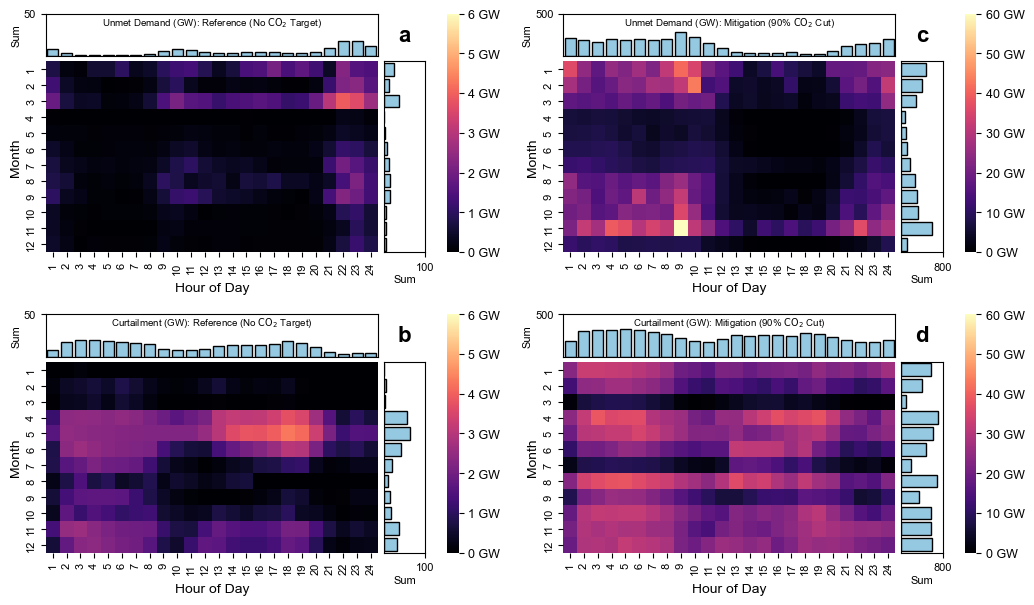

In [35]:
### heatmap with unmet demand and curtailment ###
df_list = [pt0_sw_2050,dfc0_pt,pt1_sw_2050,dfc1_pt]

# hard-coded limits for plotting
monthly_lims,moticks=[100,100,800,800],[100,100,800,800]
day_lims,dayticks=[50,50,500,500],[50,50,500,500]
colorbar_maxes=[6,6,60,60]
hr, wr, ws, hs = [1,4.5], [8,1], 0.032, 0.045
labs = ['Unmet Demand (GW): Reference (No $\mathrm{CO_{2}}$ Target)','Curtailment (GW): Reference (No $\mathrm{CO_{2}}$ Target)',
        'Unmet Demand (GW): Mitigation (90% $\mathrm{CO_{2}}$ Cut)','Curtailment (GW): Mitigation (90% $\mathrm{CO_{2}}$ Cut)']
maps=['magma','magma','magma','magma']

plt.rcParams.update(plt.rcParamsDefault)
font = FontProperties()
font.set_name('Open Sans')
plt.rcParams["font.family"] = "Arial"

fig = plt.figure(constrained_layout=False, figsize = (12,7))
gs = fig.add_gridspec(2,5, width_ratios=[1,0.03,0.16,1,0.03], height_ratios=[1,1], wspace = .13, hspace= .26)
gs00 = gs[0,0].subgridspec(2,2, height_ratios=hr, width_ratios=wr, wspace=ws,hspace=hs)
gs10 = gs[1,0].subgridspec(2,2, height_ratios=hr, width_ratios=wr, wspace=ws,hspace=hs)
gs02 = gs[0,3].subgridspec(2,2, height_ratios=hr, width_ratios=wr, wspace=ws,hspace=hs)
gs12 = gs[1,3].subgridspec(2,2, height_ratios=hr, width_ratios=wr, wspace=ws,hspace=hs)
gslist = [gs00,gs10,gs02,gs12]
ax_cb1,ax_cb2,ax_cb3,ax_cb4=fig.add_subplot(gs[0,1]),fig.add_subplot(gs[1,1]),fig.add_subplot(gs[0,4]),fig.add_subplot(gs[1,4])
cb_list = [ax_cb1,ax_cb2,ax_cb3,ax_cb4]
panel_labels = ['a','b','c','d']
fmt_strs = ["{:.0f} GW","{:.0f} GW","{:.0f} GW","{:.0f} GW"]
for y in range(len(gslist)):
    df = df_list[y]
    hourly_values = df.sum(axis=0).reset_index().rename(columns={'Hour':'Hour',0:'Sum'})
    monthly_values = df.sum(axis=1).reset_index().rename(columns={'Month':'Month',0:'Sum'})
    ax_hm = fig.add_subplot(gslist[y][1,0])   #axes for heatmap
    ax_hr = fig.add_subplot(gslist[y][0,0])   #axes for hour bars
    ax_mo = fig.add_subplot(gslist[y][1,1])   #axes for month bars
    ax_lg = fig.add_subplot(gslist[y][0,1])
    ax_lg.axis('off')
    heatmap = sns.heatmap(df, ax=ax_hm, cbar_ax=cb_list[y], annot=False, vmin=0, vmax=colorbar_maxes[y], fmt='.0f',\
                          xticklabels=np.arange(1,25),yticklabels=np.arange(1,13), cmap=maps[y])
    hour_bars = sns.barplot(x='Hour', y='Sum',data=hourly_values, ax=ax_hr, color='#88CCEE', edgecolor='k', orient='v')
    month_bars = sns.barplot(x='Sum', y='Month',data=monthly_values, ax=ax_mo, color='#88CCEE', edgecolor='k', orient='h')
    
    heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 8)
    heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 8)
    heatmap.set_xlabel('Hour of Day', fontsize=10,labelpad=6)
    heatmap.set_ylabel('Month', fontsize=10,labelpad=3)
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9)
    t = cbar.get_ticks().tolist()
    cbar.set_ticks(t)
    cbar.set_ticklabels([fmt_strs[y].format(i) for i in t])
    ax_hr.get_xaxis().set_visible(False)
    ax_hr.set_ylim(0,day_lims[y])
    ax_hr.set_yticks([dayticks[y]])
    ax_hr.set_yticklabels([str(dayticks[y])], fontsize=8)
    ax_hr.set_ylabel('Sum', fontsize=8,labelpad=2)
    ax_mo.get_yaxis().set_visible(False)
    ax_mo.set_xlim(0,monthly_lims[y])
    ax_mo.set_xticks([moticks[y]])
    ax_mo.set_xticklabels([str(moticks[y])], fontsize=8)
    ax_mo.set_xlabel('Sum', fontsize=8,labelpad=2)
    ax_hr.annotate(str(labs[y]),(.5,.8),xycoords='axes fraction',annotation_clip=False,
                        ha='center',va='center',fontsize=7)
    ax_lg.annotate(panel_labels[y],(.5,.5),xycoords='axes fraction',annotation_clip=False,
                        fontweight='bold',ha='center',va='center',fontsize=16)
plt.savefig('figure_S20.png',facecolor='w',bbox_inches='tight',dpi=600)
plt.show()

In [36]:
for y in range(4):
    df_list[y].to_csv('../sd/figS20{}.csv'.format(panel_labels[y]), index=False)